# Crystal growth

If the temperature, pressure or composition changes so will the equilibrium solid volume.
Assuming phase equilibrium would mean that this change in volume was instantaneous but
the crystal growth (or dissolution) rate is, in fact, limited. This can make it possible
to depart from phase equilibrium. This notebook outlines our approach to calculating the
crystal growth rate in the F-layer.

## Kirkpatrick (date?)

Some blurb on this needed?

## Crystal growth following Sun et al. (2018)

The Kirkpatrick growth models assume that the process of crystal growth at an interface can be described
in terms of a diffusional equation and treated as if this was solving a bulk diffusion problem (i.e. that
the Stokes-Einstien equation holds). This seems unlikly. Fortunatly, more recent work has 
attempted to quantify and understand crystal growth in metals using atomic scale simulation. Importantly,
this is a very quick process.

Here we follow Sun et al. (2018; Nature Materials 17:881-886, https://doi.org/10.1038/s41563-018-0174-6)
who simulate crystal growth of the FCC metals Al, Ni, Cu, Ag, Pt and Pb using an embedded atom model at
temperatures from the (simulated) melting point down to undercoolings of ~300 K below the melting point in order
to understand why crystal growth for these crystals was "ultrafast". These calculations were undertaken
using LAMMPS and were not at elevated pressure. These atomic scale results were compared with three models
and an emprical fit:

1. A linear fit of growth rate againts undercooling
2. The Wilson–Frenkel model, where growth is limited by diffusion in the liquid
3. A Ginzburg–Landau approach, where growth is contolled by density fluctuations in the liquid
4. A collision rate model

All these models can be described the interaction of a kinetic and a thermodynamic term (equation 1 of Sun; S1):

$$ V(T) = k(T) \left[1 - \exp\left(\frac{\Delta\mu}{k_B T}\right)  \right],$$

where $V(T)$ is the growth rate of the crystal (normal to the 111 face) $k(T)$ is a kinetic function and
$\Delta\mu$ is the difference in the chemical potential of the solid and the liquid. This is analogous to K4,
(or K8). $k(T)$ is different for the different models:

1. $k(T) = k_0$
2. $k(T) = l\frac{6D(T)}{\gamma^2}$
3. $k(T) \propto \frac{S(K_i)}{\tau(K_i)}$
3. $k(T) \propto \sqrt{\frac{3K_B T}{M}}$

Models 1 and 4 reproduce the atomic scale data fairly well over the temperature range (see Sun et al. Fig 1).

For simplicity, I'll take model 1 and write a growth rate function.

Sun SI: https://static-content.springer.com/esm/art%3A10.1038%2Fs41563-018-0174-6/MediaObjects/41563_2018_174_MOESM1_ESM.pdf

The next cells show how to calculate the growth rate for model 1 for copper.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import params 
import growth
import feo_thermodynamics

Pr =  0.09075  Sc =  999.9999999999999


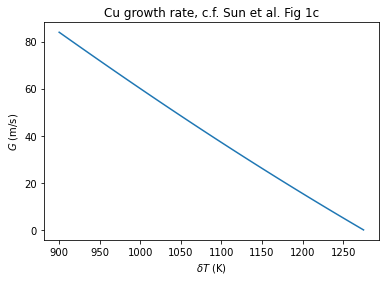

In [2]:
# Calculate growth velocity as a function of temperatue 
ts_ = np.linspace(900, params.cu_tm)
dts = params.cu_tm - ts_
vs  = growth.growth_velocity_sun(growth.sun_d_mu(dts, params.cu_tm, params.cu_dhm), params.cu_k0, ts_)

# Plot graph - like Fig 1 of paper
fig, ax = plt.subplots()
ax.plot(ts_, vs)
ax.set_xlabel('$\delta T$ (K)')
ax.set_ylabel('$G$ (m/s)')
ax.set_title('Cu growth rate, c.f. Sun et al. Fig 1c')
plt.show()

## Fe-O mixture

From the Komabayashi thermodynamic model we can calculate $\Delta\mu$ for any combination of Fe concentration in the liquid, temperature and pressure. As we'll only consider crystalisation
of solid Fe (not FeO), $\Delta\mu = \mu_{Fe}^{solid} - \mu_{Fe}^{liquid}$, growth rate will be 
positive if the composition and temperature is below and to the Fe side of the liquidus
(crystals will grow) and negative if the composition and temperature are above or to the 
right of the liquidus (crystals will melt). As crystals grow the composition of the liquid
will become enriched in O and growth rate will decrease to zero on the liquidus (when phase
equilibrium is reached). 

In some sense $k(T)$ captures limitations to growth on the crystal surface (e.g. island
neucleation) and limitations on removal of O from the interface (diffusion). It is not
totally clear how to treat these effects but for now I'll push diffusion off to a seperate
problem and assume model 1 from above (taking $k_0$ as a parameter that relates to pure
Fe). 

The next cell shows how to calculate growth rate as a function of solid volume fraction
in an FeO melt.


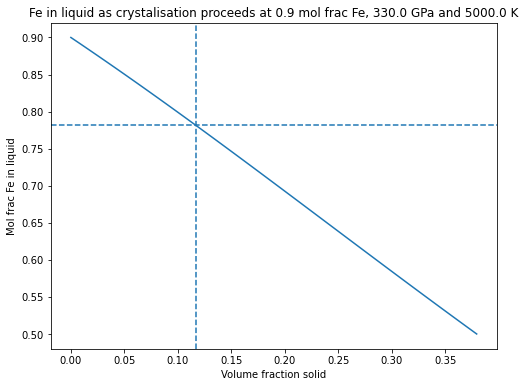

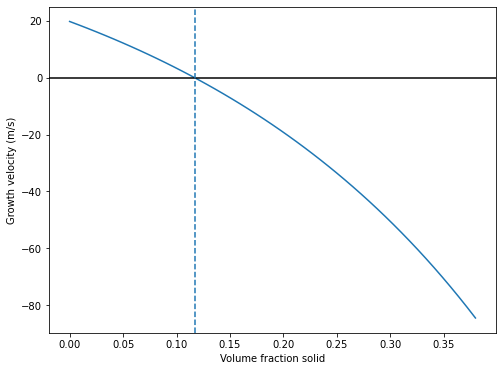

In [3]:
# Pick a point fairly deep inside the two phase region.
t = 5000.0 # K
x = 0.9 # mol frac Fe in total
p = 330.0 # GPa
k0 = 150.0 # m/s

# Setup liquid contents and volume fractions solid
# (conserve O). It is *much* easer if we go from the
# molar fraction Fe in the liquid (and total Fe mol fraction)
# to volume fraction solid than the other way around (as the)
# total volume depends on the composition of the liquid.

x_l = np.linspace(0.5, x) # Don't go too far towards FeO, it messes up

mol_frac_solid = 1.0 - (x_l/x)
mol_vol_liquid, _, _ = feo_thermodynamics.liquid_molar_volume(x_l, p, t)
_, mol_vol_solid, _ = feo_thermodynamics.solid_molar_volume(1.0, p, t)
vf_solid = (mol_frac_solid * mol_vol_solid) / (mol_frac_solid * mol_vol_solid + 
                                               (1.0 - mol_frac_solid) * mol_vol_liquid)


# For plotting only - what is equilibrium?
x_lq_eq, _, _, _, _ = \
        feo_thermodynamics.phase_relations_molar(x, p, t)
mol_frac_solid = 1.0 - (x_lq_eq/x)
mol_vol_liquid, _, _ = feo_thermodynamics.liquid_molar_volume(x_lq_eq, p, t)
_, mol_vol_solid, _ = feo_thermodynamics.solid_molar_volume(1.0, p, t)
vf_solid_eq = (mol_frac_solid * mol_vol_solid) / (mol_frac_solid * mol_vol_solid + 
                                               (1.0 - mol_frac_solid) * mol_vol_liquid)

# Plot volume fraction
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(vf_solid, x_l)
ax.axhline(x_lq_eq, ls='--')
ax.axvline(vf_solid_eq, ls='--')
ax.set_title('Fe in liquid as crystalisation proceeds at {} mol frac Fe, {} GPa and {} K'.format(x,p, t))
ax.set_xlabel('Volume fraction solid')
ax.set_ylabel('Mol frac Fe in liquid')

plt.show()

# Calculate the growth velocity - assume liquid is always well mixed (oxygen content in
# contact with solid is the same as the bulk oxygen content)
v = growth.growth_velocity_feo(x_l, p, t, k0)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(vf_solid, v)
ax.axhline(0, c='k', ls='-')
ax.axvline(vf_solid_eq, ls='--')
ax.set_xlabel('Volume fraction solid')
ax.set_ylabel('Growth velocity (m/s)')

plt.show()